# Unsupervised Techniques

* Given the join distribution for r.v.s $X$ and $Y$ is $Pr(X,Y)= Pr(Y|X)\;Pr(X)$.
* While the *supervised learning* is interesed on $Pr(Y|X)$, *unsupervised learning* is interesed on $Pr(X)$
    * Later we has a set of $N$ observations $(x_1, x_2, ... , x_N)$ of a random $p-vector$ $X$ having joint density $Pr(X)$. 
    * We aim to directly infer the properties of this probability density without the help of a supervisor or teacher providing correct answers.
* In the context of *unsupervised learning*, there is no such direct measure of success.

* *Cluster analysis* attempts to find multiple convex regions of the $X-space$ that contain modes of $Pr(X)$. This can tell whether or not $Pr(X)$ can be represented by a mixture of simpler densities representing distinct types or classes of observations.

* *Association rules* attempt to construct simple descriptions (conjunctive rules) that describe regions of high density in the special case of very high dimensional binary-valued data.

## Association Rules

* It's a popular tool for mining comercial data bases.
* The goal is to find join values of Variables $X = (X_1, ..., X_N)$ that apear most frequently in the database
* In *Market basket analysis* the $X_j$ is a *binary-value*, that is $X_j\in\{0, 1\}$, where $X_j$ is a item, and take of the value of $1$ if was bought, and $0$ if not. And the rows represent the transactions.
* Those variables that frequently have joint values of one represent items that are frequently purchased together.

### Market Basket Analysis

We are seeking the regions with high probability relative to size. This can be formulate as following:

$$Pr[\cap_{j=1}^{p} (X_j \in s_j)]$$

Where $s_j \in S_j$ (the support of $X_j$). Here $s_j$ is a set of continuous intervales if the variables are quantitative.

This is a generalize case, where the computation is so hard for big data analysis, so we need some assumptions.

$$Pr[\cap_{k \in K} I_k(if \;the\; product \;k \;is\; bought)]$$

$K \subset \{1, ..., p \}$


This is the standard formulation of the market basket problem. 

The set $K$ is called an `item set`. 

$|K|$ the number of items in the item set is called its `size`. (note that the size is no bigger than p).

The estimated value of above is taken to be the fraction of observations in the data base for which the conjunction $(\cap_{k \in K} I_k(if \;the\; product \;k \;is\; bought))$ is true

$$\frac{1}{N} \sum_{i=1}^{N}[\cap_{k \in K} I_k(if \;the\; product \;k \;is\; bought)]$$

This is called the `support` or `prevalence` $T(K)$ of the item set $K$.

An observation $i$ for which $\cap_{k \in K} I_k(if \;the\; product \;k \;is\; bought) = 1$ is said to contain the item set $K$

In association rule mining a lower support bound $t$ is specified, and one seeks all item sets $K$ that can be formed with `support` in the data base greater than this lower bound $t$

$$\{K|T(K)>t\}$$

##  The Apriori Algorithm

The Apriori Algorithm solves with a small number of passes over the data. Specifically, for a given support threshold $t$:
* The cardinality $|{K| T (K) > t}|$ is relatively small.
* Any item set $L$ consisting of a subset of the items in $K$ must have support greater than or equal to that of $K$, $L ⊆ K ⇒ T (L) ≥ T (K)$

The first pass over the data computes the support of all single-item sets. Those whose support is less than the threshold are discarded. The second pass computes the support of all item sets of size two that can be formed from pairs of the single items surviving the first pass.

The Apriori algorithm represents one of the major advances in data mining technology

Each high support itemset $K$ is partitioned into two disjoint subsets, $A ∪ B = K$, and written:
$$A ⇒ B$$

The first item subset $A$ is called the *antecedent* and the second $B$ the *consequent*

The "support" of the rule $T (A ⇒ B)$ is the fraction of observations in the union of the antecedent and consequent

It can be viewed as an estimate of the probability of simultaneously observing both item sets $Pr(A and B)$ in a randomly selected market basket

The `confidence` or `predictability` $C(A ⇒ B)$ of the rule is its support divided by the support of the antecedent.

$$C(A ⇒ B) = \frac{T (A ⇒ B)} {T (A)}$$

Which can be viewed as an estimate of $Pr(B | A)$

The `expected confidence` is defined as the support of the consequent $T (B)$, which is an estimate of the unconditional probability $Pr(B)$

The `lift` of the rule is defined as the *confidence* divided by the *expected confidence*

$$L(A ⇒ B) = \frac{C(A ⇒ B)}{T (B)}$$

Given $L(A \Rightarrow B) = k$, $C(A \Rightarrow B) = P(B|A) = k$ and $T(B) = P(B)$.

We can write the `lift` as

$$P(B|A) = k \; P(B)$$

We suposse that $P(B) = 50\%$ and $P(B|A) = 75\%$, then $k = 1.5$, that means the effect of $A$ on $B$ in positive since it increment the probability. 

In [1]:
import numpy as np
from itertools import combinations, product
import pandas as pd, re

In [2]:
class Basket:
    
    def __init__(self, df:pd.DataFrame):
        """
        Columns of data frame must be binary values. I = 0 or 1
        Rows must be an id id some customer
        """
        self.X = df.values
        self.columns = df.columns.astype(str).values
        self.X_dumm = self.X == 1
    
    def UniSupport(self, t=0):
        """ 
        This compute the support of itemset I, where length is 1, |I|=1 
        """
        self.uni_t = t
        X_support = self.X_dumm.mean(axis=0)
        self.condition = X_support>t
        self.X_support_serie = pd.Series(X_support[self.condition],self.columns[self.condition] , name = 'UniSupport',)
        X_support_serie_export = self.X_support_serie.copy()
        X_support_serie_export.index = X_support_serie_export.index.str.replace(r'((?:.|\s)+)', r'T(\1)', regex=True)

        return X_support_serie_export
    
    def PairSupport(self, t):
        """ 
        This compute the support of itemset I, where length is 2, |I|=2,
        given the min support above specified
        """
        self.pair_t = t
        feat_indx = np.where(self.condition)[0]
        support_pair_select = {}

        for comb in combinations(feat_indx, 2):
            X_support_select = self.X_dumm[:, comb].all(axis = 1).mean()
            columns_select = self.columns[np.asarray(comb)]
            if X_support_select > t:
                support_pair_select[tuple(columns_select)] = X_support_select
        self.support_pair_select_serie = pd.Series(support_pair_select, name='PairSupport')
        support_pair_select_serie_export = self.support_pair_select_serie.copy()
        support_pair_select_serie_export.index = ['T('+','.join(x) +')' for x in  support_pair_select_serie_export.index]
        support_pair_select_serie_export.index.name = 'T(A,B)'
        
        return support_pair_select_serie_export

    def Confidence(self, given_set = 'A'):
        
        self.given_set = given_set
        df_support_uni = self.X_support_serie.reset_index().copy()
        df_support_uni.rename(columns={'index':f'{self.given_set}', 'UniSupport':f'UniSupport_{self.given_set}'}, inplace=True)
        df_support_uni[f'T({self.given_set})'] = self.UniSupport(self.uni_t).index
        
        self.support_pair_select_serie.index = self.support_pair_select_serie.index.set_names(['A', 'B'])
        df_support_pair = self.support_pair_select_serie.reset_index()
        df_support_pair['T(A,B)'] = self.PairSupport(self.pair_t).index

        df_support_total = df_support_pair.merge(df_support_uni, on=f'{self.given_set}')
        df_support_total[f'T(A,B)/T({self.given_set})'] = df_support_total['T(A,B)'].add('/' + df_support_total[f'T({self.given_set})'])
        df_support_total.set_index(f'T(A,B)/T({self.given_set})', inplace=True)
        df_support_total['Confidence'] = df_support_total['PairSupport']/df_support_total[f'UniSupport_{self.given_set}']
        self.df_support_total = df_support_total
        
        return  df_support_total['Confidence']

    def Lift(self):
        lift_set = 'B' if self.given_set == 'A' else 'A'
        
        df_support_uni = self.X_support_serie.reset_index().copy()
        df_support_uni.rename(columns={'index':f'{lift_set}', 'UniSupport':f'UniSupport_{lift_set}'}, inplace=True)
        df_support_uni[f'T({lift_set})'] = self.UniSupport(self.uni_t).index

        df_support_total_lift = self.df_support_total.merge(df_support_uni, on = f'{lift_set}', how='left')
        df_support_total_lift['Lift'] = df_support_total_lift['Confidence']/df_support_total_lift[f'UniSupport_{lift_set}']
        df_support_total_lift.index = (
            df_support_total_lift["T(A,B)"] + "/" + df_support_total_lift[f"T({self.given_set})"] + df_support_total_lift[f"T({lift_set})"])
        df_support_total_lift.index.name = f"T(A,B)/T({self.given_set})T({lift_set})"

        return  df_support_total_lift['Lift']

In [3]:
data_total = pd.read_csv(r'C:\Users\LENOVO\Desktop\projects\3.- STS\data_microsoft.csv', sep=',')

In [4]:
data_user_cross = pd.crosstab(data_total['user_ID'], data_total['attribute_ID'])
data_user_cross.columns = data_user_cross.columns.astype(str)

In [55]:
data_user_cross['CategoricalVariable'] = np.random.randint(1, 7, 32711)
data_user_cross['CategoricalVariable1'] = np.random.randint(1, 5, 32711)

In [56]:
columns_products = data_user_cross.columns[data_user_cross.columns.str.contains(r"\d{4}", regex=True)]

In [27]:
basket = Basket(data_user_cross[columns_products])

In [28]:
basket.UniSupport(0.05)

T(1001)    0.136070
T(1003)    0.090734
T(1004)    0.258720
T(1008)    0.331265
T(1009)    0.141481
T(1017)    0.156155
T(1018)    0.162942
T(1025)    0.064902
T(1026)    0.098438
T(1034)    0.286845
T(1035)    0.054752
Name: UniSupport, dtype: float64

In [29]:
basket.PairSupport(0.04)

T(A,B)
T(1001,1003)    0.055211
T(1001,1004)    0.048577
T(1001,1018)    0.059430
T(1003,1018)    0.046896
T(1004,1008)    0.060438
T(1004,1017)    0.049891
T(1004,1018)    0.044786
T(1004,1034)    0.053285
T(1008,1009)    0.077925
T(1008,1017)    0.061233
T(1008,1018)    0.073064
T(1008,1034)    0.160802
T(1009,1018)    0.045000
T(1017,1034)    0.047354
T(1018,1034)    0.042982
T(1018,1035)    0.046070
Name: PairSupport, dtype: float64

In [30]:
# wsws.index.get_indexer(['T(1000,1003)'])

In [31]:
basket.Confidence('A') 

T(A,B)/T(A)
T(1001,1003)/T(1001)    0.405752
T(1001,1004)/T(1001)    0.356998
T(1001,1018)/T(1001)    0.436756
T(1003,1018)/T(1003)    0.516846
T(1004,1008)/T(1004)    0.233605
T(1004,1017)/T(1004)    0.192839
T(1004,1018)/T(1004)    0.173106
T(1004,1034)/T(1004)    0.205955
T(1008,1009)/T(1008)    0.235234
T(1008,1017)/T(1008)    0.184847
T(1008,1018)/T(1008)    0.220561
T(1008,1034)/T(1008)    0.485419
T(1009,1018)/T(1009)    0.318064
T(1017,1034)/T(1017)    0.303250
T(1018,1034)/T(1018)    0.263790
T(1018,1035)/T(1018)    0.282739
Name: Confidence, dtype: float64

In [32]:
basket.Lift() 

T(A,B)/T(A)T(B)
T(1001,1003)/T(1001)T(1003)    4.471879
T(1001,1004)/T(1001)T(1004)    1.379862
T(1001,1018)/T(1001)T(1018)    2.680435
T(1003,1018)/T(1003)T(1018)    3.171963
T(1004,1008)/T(1004)T(1008)    0.705192
T(1004,1017)/T(1004)T(1017)    1.234920
T(1004,1018)/T(1004)T(1018)    1.062380
T(1004,1034)/T(1004)T(1034)    0.718001
T(1008,1009)/T(1008)T(1009)    1.662652
T(1008,1017)/T(1008)T(1017)    1.183736
T(1008,1018)/T(1008)T(1018)    1.353616
T(1008,1034)/T(1008)T(1034)    1.692267
T(1009,1018)/T(1009)T(1018)    1.952006
T(1017,1034)/T(1017)T(1034)    1.057189
T(1018,1034)/T(1018)T(1034)    0.919624
T(1018,1035)/T(1018)T(1035)    5.163977
Name: Lift, dtype: float64

# Cluster Analysis

The goal of cluster analysis is grouping or segmetation a collection of objects in subsets.

Central to all of the goals of cluster analysis is the notion of the degree of similarity (or dissimilarity) between the individual objects being clustered.

A clustering method attempts to group the objects based on the definition of similarity supplied to it.

There the `cost associated` with an inaccurate prediction depends on considerations outside the data.

To all `clustering techniques` is the choice of *distance* or *dissimilarity* *measure* between two objects.

## Proximity Matrices



The proximity of the data can be measured by *similarity* or *dissimilarity*, this is usually the input of the algorithm to get the clusters.

Given $x_{i,j}$ where $i=1, 2, ..., N$ is the record for each variable $j = 1, 2, ..., p$

In the step $1$ we define a  dissimilarity measurement between the observations.

The *dissimilarity*  between values of the $j$ th attribute is defined by $d_{j}(x_{i,j}, x_{i′,j})$ and defined the The *dissimilarity*  between object $i$ and $i´$ like
$$D(x_{i}, x_{i′}) = \sum_{j=1}^{p}d_{j}(x_{i,j}, x_{i′,j})$$

The most common choice is squared distance

$$d_j(x_{i,j}, x_{i′,j}) = (x_{i,j} − x_{i′,j})^2$$

For example, given the following Table 1
<center>

|$x_1$|$x_2$|$x_3$|
|:---:|:---:|:---:|
|1.5|2.6|9.5|
|2.5|2.8|5|
|3.5|8|7|
|3.7|4.5|7.6|

</center>

We can compute the dissimilarity between the first record and second record for the third variable.

$$d_3(x_{1,3}, x_{2,3}) = (9.5 - 5)^2  = 20.25 $$

There are severals measurements for each type of variable, but we will focus on *quantitative* variable.

We have yet seen one of them (squared distance), but exist others.

* Absolute difference:
$$d_j(x_{i,j}, x_{i′,j}) = l(|x_{i,j} - x_{i′,j}|)$$
* Correlation:
$$p_{i,i´}=\frac{\sum_j(x_{i,j} - \bar{x_i}) (x_{i´,j} - \bar{x_{i´}})}{ \sqrt{\sum_j (x_{i,j} - \bar{ x_i})^2 \sum_j(x_{i´,j} - \bar{x_{i´}})^2}}$$

with $\bar{x_i} = \sum_j x_{i,j}/p$. Note that this is averaged over *variables*

Following with the above example
* Absolute difference $d_3(x_{1,3}, x_{2,3}) = |9.5 - 5| = 4$
* Correlation $p_{1,2} = 0.99985431$

In [1]:
import numpy as np

X = np.array([
    [1.5, 2.6, 9.5],
    [2.5, 2.8, 5],
    [3.5, 8, 7],
    [3.7, 4.5, 7.6]]
    )
np.corrcoef(X[:2,:])

array([[1.        , 0.99985431],
       [0.99985431, 1.        ]])

If the observations are first standardized both *correlation* and *squared distance* are similar  

## Object Dissimilarity

If we know the importances of the features we can compute the *weigthed* distance.

$$D(x_{i}, x_{i′}) = \sum_{j=1}^{p} w_j d_{j}(x_{i,j}, x_{i′,j})$$

where $$\sum_{j=1}^{p}w_j = 1$$

It is important to realize that setting the weight $w_j$ to the same value for each variable (say, $w_j = 1$ $∀j$) does not necessarily give all attributes equal influence. 

The *influence* of the $j$ th attribute $X_j$ on object dissimilarity $D(x_i, x_{i′})$ depends upon its relative contribution to the average object dissimilarity measure over all pairs of observations in the data set (for all variables):

$$\bar{D}=\frac{1}{N^2} \sum_{i=1}^{N} \sum_{i´=1}^{N} D(x_i, x_{i´}) = \sum_{j=1}^{p} w_j \bar{d_j}$$

where

$$\bar{d_j} = \frac{1}{N^2} \sum_{i=1}^{N} \sum_{i´=1}^{N} d_j(x_{i,j}, x_{i´,j})$$

Here $\bar{d_j}$ is the average dissimilarity on the $j$ th attribute.

If we set $ w_j = \frac{1}{\bar{d_j}}$ , then all variables would have the same infludence on the average object dissimilarity measure.

Joining $ w_j\bar{d_j}$ represent the relative importance of each variable $j$. Where $w_j$ is subject and $\bar{d_j}$ come from data.

If we set the measure of the dissilarity as squared Euclidean distance
$$d_j(x_{i,j}, x_{i′,j}) = (x_{i,j} − x_{i′,j})^2$$

Then the average dissimilarity on the $j$ th attribute become in:

$$\bar{d_j} = \frac{1}{N^2} \sum_{i=1}^{N} \sum_{i´=1}^{N} d_j(x_{i,j}, x_{i´,j}) = 2 var_j$$

Thus, the relative importance of each such variable is proportional to its variance over the data sets.

In this case is no recomended to *standar* before apply the algorithm in oder to cluster, since if we standar the data set it is as if we were applying $w_i = \frac{1}{2var_j}$

The standardization obscure the clusters

Specifying an appropriate dissimilarity measure is far more important in obtaining success with clustering than choice of clustering algorithm. 

The *Missing values* can be dropped or we can input the median or mean of the variable $j$ on the missing values.


In order to practice we wil compute the average dissimilarity of $x_3$, that is, $d_3$

In [2]:
from itertools import permutations

def ds(x):
    """
    Compute the dissimilarity
    """
    return sum((s[0] - s[1])**2 for s in permutations(x, 2))/len(x)**2
    
print("Dissimilarity: " , ds(X[:, 2]))
print("Dissimilarity: " , 2 * X[:, 2].var()) 

Dissimilarity:  5.15375
Dissimilarity:  5.1537500000000005


## Clustering Algorithms

## K-means

Given a dataset, each observation is uniquely labeled by an integer $i ∈ {1, · · ·, N}$. 

A prespecified number of clusters $K < N$ is postulated, and each one is labeled by an integer $k ∈ {1, . . . , K}$. 

Each observation is assigned to one and only one cluster. 

These assignments can be characterized by a *many-to-one* mapping, or *encoder* $k = C(i)$, that assigns the $i$ th observation to the $k$ th cluster

One seeks the particular encoder $C^∗(i)$ that achieves minimizing the loss function (this based on the dissimilarities $d(x_i, x_{i′}$) between every pair of observations). In particular, we must change the assigments made before until minimizing the loss function.



Since the goal is to assign close points to the same cluster, a natural *loss function* would be

$$W (C) = \sum_{k =1}^{K} \sum_{C(i)=k} \sum_{C(i´)=k} d(x_{i}, x_{i′})$$

If we use the like object dissimilarity the squared Euclidean distance, that is, $d(x_i, x_{i′}) = \sum_{j=1}^{p} (x_{ij} − x_{i′j})^2 = ||x_{i} − x_{i′}||^2 $, we can write the loss function as follows

$$W (C) = \sum_{k =1}^{K} \sum_{C(i)=k} ||x_{i} − \bar{x}_{k}||^2$$

Where $\bar{x}_k $ is the mean associated with the $k$ th cluster.

Thus, the criterion is minimized by assigning the $N$ observations to the $K$ clusters in such a way that within each cluster the average dissimilarity of the observations from the cluster mean, as defined by the points in that cluster, is minimized.

$$C^* = \min_{c} \sum_{k =1}^{K} \sum_{C(i)=k} ||x_{i} − \bar{x}_{k}||^2$$

can be obtained by noting that for any set of observations $S$

$$\hat{x}_S = \argmin_m \sum_{i∈S} ||x_i − m||^2$$

**Algorithm** 

1. For a given cluster assignment $C$, the total cluster variance  is minimized with respect to ${m_1, . . . , m_K}$ yielding the means of the currently assigned clusters.

2. Given a current set of means ${m_1, . . . , m_K}$, is minimized by assigning each observation to the closest (current) cluster mean. That is, 

$$C(i) = \argmin_{1≤k≤K} ||x_i − m_k||^2$$

3. Steps 1 and 2 are iterated until the assignments do not change.

This is the reason why Kmeans clustering is a *top-down* procedure.

We can write the code that do this but, there already is one in `sklearn`

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.cluster import KMeans

In [4]:
# Load the data
data_crime = pd.read_stata(r'data_dta/CRIME1.dta')

# Generate the variable arr86, where a person is labeled equal to 0, if he has not committed a crime in 1986
# otherwise 1.
data_crime['arr86'] = data_crime.narr86.where(data_crime.narr86==0, 1)

# Selecting the features and target
features= ['pcnv', 'avgsen', 'tottime', 'ptime86', 'qemp86']
target = 'arr86'

X = np.array(data_crime[features])
y = np.array(data_crime[target])

# Split the data to train and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=123, test_size=0.25)

In [5]:
kmeans = KMeans(n_clusters=4, n_init=20)
kmeans.fit(X_train)
clusters = kmeans.predict(X_train)

* `init='k-means++' `: it makes it possible to drastically reduce the number of times the algorithm needs to be run to find the optimal solution. 
  This selects centroids that are distant from one another.

* `n_init = 10`: 10 times the algorithm run with different random initializations and keep the best solution.

* `kmeans.cluster_centers_`: get the centroides by cluster, the means of the features by cluster.

* `kmeans.transform(X)`: transform `X` by this distances to centroides.


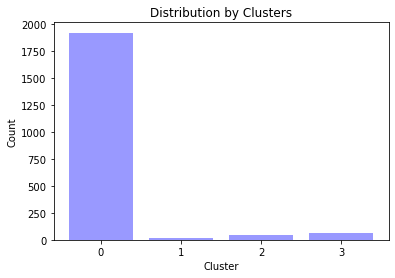

In [6]:
fig, ax = plt.subplots()

label_cluster, counts_cluster = np.unique(clusters, return_counts=True)
label_cluster = label_cluster.astype(str)

ax.bar(label_cluster, counts_cluster, color = 'blue', alpha = 0.4 )
ax.set(xlabel = 'Cluster', ylabel = 'Count', title = 'Distribution by Clusters')
plt.show()

### Using Clustering for Preprocessing

Given a initial model, can apply the `kmeans` like preprocessing.

Firstly, the initial model

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from assets.unsupervised import utils_metrics

In [8]:
logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)

LogisticRegression()

In [9]:
utils_metrics.print_metrics(y_test, X_test, logit_model)

The accuracy 0.7243
Initial AUC value is 0.6017

Probability Conditioned on Predicts
> P(not committed a crime|low risk)   72.82%
> P(not committed a crime|high risk)  80.00%
> P(committed a crime|low risk)       27.18%
> P(committed a crime|high risk)      20.00%

Probability Conditioned on Outcomes
> P(low risk|not committed a crime)   99.20%
> P(high risk|not committed a crime)  0.80%
> P(low risk|committed a crime)       99.46%
> P(high risk|committed a crime)      0.54%

Confusion Matrix
> [[493   4]
 [184   1]]



The pipeline works by steps. 

In this case:
* The first step is transform the data using `k-means`. Internally, is got the 4 clusters and they are used to transform the data. Similar to apply `kmeans.tranform`.
* Once, the transform the data, we fit them using a model, in this case, `LogisticRegression`

In [10]:
pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=4, n_init=20)),
         ("logistic", LogisticRegression(max_iter=800)),
         ])
         
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=4, n_init=20)),
                ('logistic', LogisticRegression(max_iter=800))])

In [11]:
utils_metrics.print_metrics(y_test, X_test, pipeline)

The accuracy 0.7273
Initial AUC value is 0.6154

Probability Conditioned on Predicts
> P(not committed a crime|low risk)   72.90%
> P(not committed a crime|high risk)  66.67%
> P(committed a crime|low risk)       27.10%
> P(committed a crime|high risk)      33.33%

Probability Conditioned on Outcomes
> P(low risk|not committed a crime)   99.60%
> P(high risk|not committed a crime)  0.40%
> P(low risk|committed a crime)       99.46%
> P(high risk|committed a crime)      0.54%

Confusion Matrix
> [[495   2]
 [184   1]]



We can see the AUC is increased.

#### Traking a Map

The goal is monitoring the amount of color in a map, this can be applied in the bussiness, for instance, a company can monitor their infludence area or their costumers.

The requirements are:
* The images can be compared if, and only if, the size of the pixels are the same.
* The areas are the same.

In [37]:
from matplotlib.image import imread
from IPython.display import Image as ImageDisplay

# read the files and convert to numpy arrays by pixel
image_map = imread(r'assets/unsupervised/map.JPG')
print('Height: {}, Weight: {} in pixels descomposed in tuple {} (red, green, blue)'.format(*image.shape))

Height: 444, Weight: 1308 in pixels descomposed in tuple 3 (red, green, blue)


In [42]:
# we join the pixels in a single array
map_array = image_map.reshape(image_map.shape[0]*image_map.shape[1], 3)

In [44]:
kmeans = KMeans()
kmeans.fit(map_array)

KMeans()

In [45]:
kmeans_labels = kmeans.predict(map_array)

In [118]:
classes, counts = np.unique(kmeans_labels, return_counts=True)
counts_normalize = counts/counts.sum()

In [190]:
import matplotlib.patches as patches

def color_swatches(colors):

    ncolors = len(colors)
    fig, ax = plt.subplots(figsize=(ncolors*2, 2))

    for (start_x, color) in enumerate(colors):
        color_rect = patches.Rectangle((start_x, 0), 1, 1, color=color)
        ax.add_patch(color_rect)

    ax.set_xlim(0, len(colors))
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_xticklabels([])

    return fig

Perecentage of composition [ 3.8  25.71  8.83 24.13 12.34  8.21  7.27  9.72]


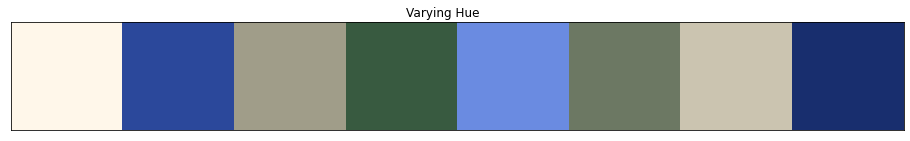

In [200]:
colors = list(kmeans.cluster_centers_/kmeans.cluster_centers_.max())
fig = color_swatches(colors)
fig.suptitle("Varying Hue")
print("Perecentage of composition: ",counts_normalize.round(4)*100)

In [189]:
# Confidence Interval of the KMeans
sample_total = 800
for cluster, size in zip(classes, counts_normalize):
    # Population
    map_array_cluster = map_array[kmeans_labels == cluster].copy()
    idx = np.random.randint(0, len(map_array_cluster), size = int(sample_total*size))
    # Sample
    sample_map = map_array_cluster[idx,:].copy()
    # Coincidence Interval
    for sign in [-1, 1]:
        ci = np.mean(sample_map, axis=0) + \
            sign * 1.96 * np.std(sample_map, axis=0)/np.sqrt(len(sample_map))
        bound = 'lower' if sign == -1 else 'upper'
        print(f'-> CI {bound} of class {cluster}', ci)

-> CI lower of class 0 [185.12580946 178.7628049  165.52278049]
-> CI upper of class 0 [197.80752388 191.2371951  180.74388618]
-> CI lower of class 1 [ 31.22474299  51.88242917 113.40893994]
-> CI upper of class 1 [ 33.17525701  54.02976596 116.25935275]
-> CI lower of class 2 [113.54055628 112.05672848  96.79225317]
-> CI upper of class 2 [118.68801515 116.34327152 102.1791754 ]
-> CI lower of class 3 [39.45149938 66.16030021 45.97117024]
-> CI upper of class 3 [41.63658352 68.37855989 48.03919245]
-> CI lower of class 4 [ 74.50415216  99.12386883 160.30716247]
-> CI upper of class 4 [ 79.31217437 103.89653933 165.40712325]
-> CI lower of class 5 [79.13940742 85.35677458 69.75694337]
-> CI upper of class 5 [85.47597719 90.1201485  74.6122874 ]
-> CI lower of class 6 [145.61995018 141.06764408 126.29551186]
-> CI upper of class 6 [152.20763603 146.58752833 131.98035021]
-> CI lower of class 7 [16.34425232 32.03615003 78.14790031]
-> CI upper of class 7 [19.34405937 35.75605777 85.1248

In [97]:
predict_map = kmeans.cluster_centers_[kmeans_labels]
predict_map_normalize = predict_map.reshape(image_map.shape)

In [100]:
from PIL import Image
img_map_out = Image.fromarray(predict_map_normalize.astype("uint8") , 'RGB')
img_map_out.save("./assets/unsupervised/map_predict.png")

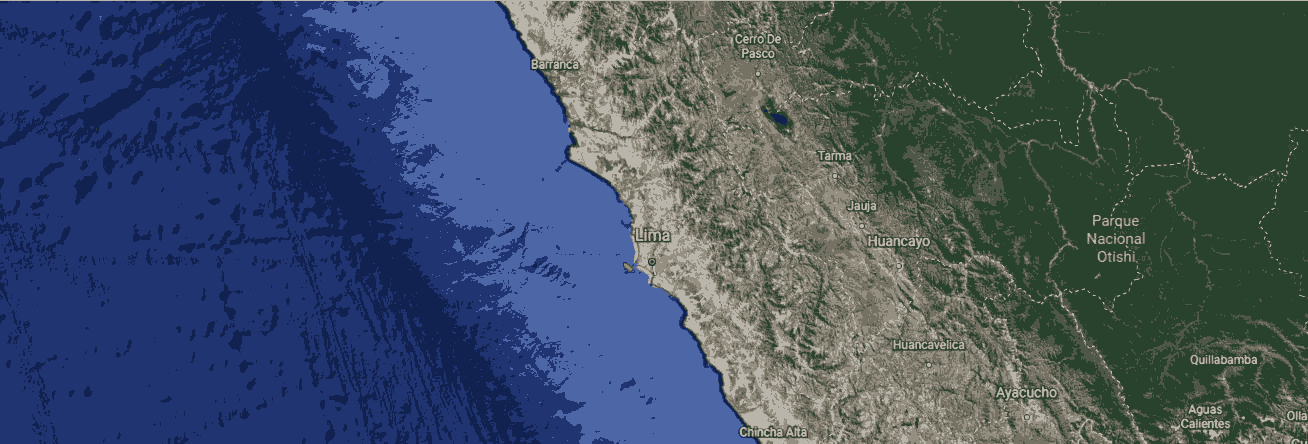

In [101]:
ImageDisplay("assets/unsupervised/map_predict.png")

## Density-Based Clustering - DBSCAN

* Clusters are dense regions in the data space, separated by regions of lower object density
* A cluster is defined as a maximal set of densityconnected points
* Discovers clusters of arbitrary shape

Density Definition 

* $\epsilon$ - Neighborhood: Objects within a radius of from an object.
 $$N_{\epsilon}(p) = \{ q | d(p, q) \leq \epsilon \}$$

* *High density*: $ε$ - Neighborhood of an object contains at least *MinPts* of objects.
  
  Given MinPts = 4, $p$ is *high density*, but $q$ is *low density*.

<span style="display:block;text-align:center">
    <img src="assets/unsupervised/minpts.JPG" />
</span>

Given $\epsilon$ and *MinPts*, then the data is clustering

* A point is a *core point* if it has more than a specified number of points (MinPts) within Eps—These are points that are at the interior of a cluster.
* A *border point* has fewer than *MinPts* within Eps, but is in the neighborhood of a core point.
* A *noise point* is any point that is not a core point nor a border point

<span style="display:block;text-align:center">
    <img src="assets/unsupervised/grouping.JPG" />
</span>

In this case $\epsilon = 1 cm.$ and *MinPts* $= 5$

**Density-reachability**

* Directly density-reachable

  An object $q$ is directly *density-reachable* from object $p$ if $p$ is a *core object* and $q$ is in $p$’s $\epsilon$-neighborhood. Two conditions.

  So Given the following parameters $\epsilon = 1 cm.$ and *MinPts* $= 4$ and the image.

  * $q$ is directly density-reachable from $p$
  * $p$ is not directly density-reachable from $q$
  * Density-reachability is asymmetric

<span style="display:block;text-align:center">
    <img src="assets/unsupervised/grouping_01.JPG" />
</span>

* Density-Reachable (directly and indirectly)

  So Given the following parameters $\epsilon = 1 cm.$ and *MinPts* $= 7$ and the image.

  * A point $p$ is directly density-reachable from $p_2$ 
  * $p_2$ is directly density-reachable from $p_1$
  * $p_1$ is directly density-reachable from $q$
  * $p \leftarrow p_2 \leftarrow  p_1 \leftarrow q$ form a chain
  * $p$ is (indirectly) density-reachable from $q$, the inverse is false.

<span style="display:block;text-align:center">
    <img src="assets/unsupervised/grouping_02.JPG" /> 
</span>

When DBSCAN Works Well

* Resistant to Noise
* Can handle clusters of different shapes and sizes

When DBSCAN Does NOT Work Well

* Cannot handle varying densities
*  sensitive to parameters—hard to determine the correct set of parameters

In [370]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

* `dbscan.labels_`: get the clusters
  * A cluster index equal to -1 point out that they are considered as anomalies by the algorithm.
* `dbscan.core_sample_indices_`: get the indeces of teh cores.
* `dbscan.components_`: the data to get the cores.

In [371]:
# labels
labels_clusters = dbscan.labels_

# uniques clusters
clusters = np.unique(labels_clusters)

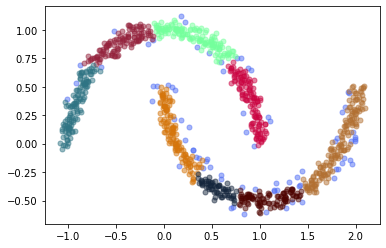

In [386]:
def plot_fig(clusters, labels_clusters):
    _, ax = plt.subplots()
    random_abs = np.abs(np.random.randn(len(clusters), 3))
    colors = np.abs(random_abs)/random_abs.max()

    for (cluster, color) in zip(clusters, colors):
        ax.scatter(
            X[labels_clusters == cluster,0], 
            X[labels_clusters == cluster,1], 
            alpha = 0.5, 
            s = 25, 
            color = tuple(color) 
        )

np.random.seed(599)
plot_fig(clusters, labels_clusters)

In [330]:
dbscan = DBSCAN(eps=0.2, min_samples=10)
dbscan.fit(X)

DBSCAN(eps=0.2, min_samples=10)

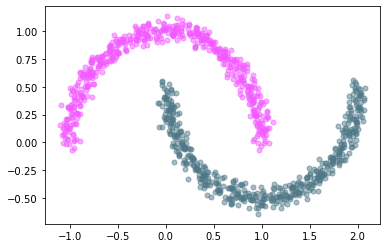

In [367]:
labels_clusters = dbscan.labels_

clusters = np.unique(labels_clusters)

np.random.seed(128)
plot_fig(clusters, labels_clusters)

## Hierarchical Clustering

* K-means or K-medoids clustering algorithms depend on the choice for the number of clusters.

* Hierarchical clustering methods require the user to specify a measure of dissimilarity between (disjoint) groups of observations based on the pairwise dissimilarities among the observations in the two groups.

* they produce hierarchical representations in which the clusters at each level of the hierarchy are created by merging clusters at the next lower level. 

  At the lowest level, each cluster contains a single observation. At the highest level there is only one cluster containing all of the data. 

* Strategies:
  * *Agglomerative*: start at the bottom and at each level recursively merge a selected pair of clusters into a single cluster. 
  
    This produces a grouping at the next higher level with one less cluster. 
    
    The pair chosen for merging consist of the two groups with the smallest intergroup dissimilarity. 
  
  * *Divisive*: start at the top and at each level recursively split one of the existing clusters at that level into two new clusters.

    The split is chosen to produce two new groups with the largest between-group dissimilarity. 


* With both paradigms there are N − 1 levels in the hierarchy.

* Each level of the hierarchy represents a particular grouping of the data into disjoint clusters of observations. 

* The user to decide which level (if any) actually represents a “natural” clustering

* That is, observations within each of its groups are sufficiently more similar to each other than to observations assigned to different groups at that level.

**Dendrogram**

* Recursive binary splitting/agglomeration can be represented by a rooted binary tree. 

* The nodes of the trees represent groups.
  * The root node represents the entire data set. 
  * The $N$ terminal nodes each represent one of the individual observations (singleton clusters). 
  * Each nonterminal node (`parent`) has two daughter nodes. 

    * For *divisive* clustering the two daughters represent the two groups resulting from the split of the parent.
    
    * For *agglomerative* (the most studied) clustering the daughters represent the two groups that were merged to form the parent.
  
  * The binary tree can be plotted so that the *height* of each node is proportional to the value of the intergroup dissimilarity between its two daughters. 
  
  * The terminal nodes representing individual observations are all plotted at zero height.

  * Cutting the *dendrogram* horizontally at a particular height partitions the data into disjoint clusters represented by the vertical lines that intersect it. These are the clusters that would be produced by terminating the procedure when the optimal intergroup dissimilarity exceeds that threshold cut value. 

  * Groups that merge at high values, relative to the merger values of the subgroups contained within them lower in the tree, are candidates for natural clusters.

  * Caution about *dendrogram*:
    * **Different hierarchical methods** (see below), and **small changes** in the data, can lead to quite different dendrograms. 


**Agglomerative Clustering**

* Agglomerative clustering algorithms begin with every observation representing a singleton cluster. At each of the $N −1$ steps the closest two (least dissimilar) clusters are merged (given a measure of dissimilarity) into a single cluster, producing one less cluster at the next higher level

* Let $G$ and $H$ represent two groups. The dissimilarity $d(G, H)$ between $G$ and $H$ under **Single linkage (SL)** agglomerative clustering takes the intergroup dissimilarity to be that of the closest (least dissimilar) pair 

$$d_{S,L} (G, H) = \min_{i \in G, i´ \in H} d_{i, i´}$$

* **Complete linkage** (CL) agglomerative clustering (furthest-neighbor technique) takes the intergroup dissimilarity to be that of the furthest (most dissimilar) pair

$$d_{S,L} (G, H) = \max_{i \in G, i´ \in H} d_{i, i´}$$

* **Group average** (GA) clustering uses the average dissimilarity between the groups

$$d_{S,L} (G, H) = \frac{1}{N_G N_H} \sum_{i \in G} \sum_{i´ \in H} d_{i, i´}$$

* **Ward's** minimum variance criterion minimizes the total within-cluster variance. 

  To implement this method, at each step find the pair of clusters that leads to minimum increase in total within-cluster variance after merging. 
  
  This increase is a weighted squared distance between cluster centers. At the initial step, all clusters are singletons (clusters containing a single point). 
  
  To apply a recursive algorithm under this objective function, the initial distance between individual objects must be (proportional to) squared Euclidean distance.
  
  The initial cluster distances in Ward's minimum variance method are therefore defined to be the squared Euclidean distance between points:

$$ d_{ij}=d(\{X_{i}\},\{X_{j}\})= \|X_{i}-X_{j}\|^{2}.$$
Note: In software that implements Ward's method, it is important to check whether the function arguments should specify Euclidean distances or squared Euclidean distances.

Where $N_G$ and $N_H$ are the respective number of observations in each group.

The algorithms works very well if the data are compacted

> User Case:
> 
> Many clusters, possibly connectivity constraints, transductive (transduction or transductive inference is reasoning from observed, specific (training) cases to specific (test) cases)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection

In [24]:
# Load the data
data_drime = pd.read_stata(r'data_dta/CRIME1.dta')
# Metadata --> http://eswf.uni-koeln.de/daten/crime1.htm

# Generate the variable arr86, where a person is labeled equal to 0, if he or she has not arrested in 1986
# otherwise 1.
data_drime['arr86'] = np.where(data_drime.narr86 == 0, data_drime.narr86, 1)

# select the columns with dtype float64
columns_float = data_drime.dtypes[(data_drime.dtypes == np.float64) | (data_drime.dtypes == np.float32)].index.copy()

In [64]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')

In [63]:
X = data_drime[columns_float].copy()

In [69]:
# Unsupervised learning like supervised learning, but without a label.
(cluster.fit_predict(X)  == data_drime.arr86).mean()

0.6895412844036697